<a href="https://colab.research.google.com/github/sAI-2025/OCT_Retinal_Segmentation/blob/main/U_net_Oct_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf,os,random,matplotlib.pyplot as plt,cv2,numpy as np,scipy.misc,numpy.random as rng,glob,math,keras,nibabel as nib
from tqdm import tqdm #reading nifti images
from skimage.io import imread, imshow
from skimage.transform import resize
from keras.layers import Input,Dense,Flatten,Dropout,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K

# File Extraction

In [ ]:
pip install rarfile


In [ ]:
import rarfile
import os

def extract_rar(rar_path, extract_to_dir):
    # Ensure the output directory exists
    if not os.path.exists(extract_to_dir):
        os.makedirs(extract_to_dir)

    # Open the RAR file
    with rarfile.RarFile(rar_path) as rf:
        # List the contents of the RAR file
        print("Contents of the RAR file:")
        for file_info in rf.infolist():
            print(f" - {file_info.filename}")

        # Extract all files
        rf.extractall(path=extract_to_dir)
        print(f"All files extracted to {extract_to_dir}")

if __name__ == "__main__":
    rar_file_path = '/content/drive/MyDrive/Colab Notebooks/Git/Datasets/NR206_Full_Version.rar'  # Replace with your RAR file path
    output_directory = '/content/drive/MyDrive/Colab Notebooks/Git/Datasets/'  # Replace with your output directory path

    extract_rar(rar_file_path, output_directory)


# Ploting Some labels

Image Path: /content/drive/MyDrive/Colab Notebooks/Git/Datasets/NR206_Full_Version/NR206/train/NORMAL100.png
Image Shape: (500, 750, 3)
Label Path: /content/drive/MyDrive/Colab Notebooks/Git/Datasets/NR206_Full_Version/NR206/train_labels/NORMAL100.png
Label Shape: (500, 750, 3)
Image Path: /content/drive/MyDrive/Colab Notebooks/Git/Datasets/NR206_Full_Version/NR206/train/NORMAL189.png
Image Shape: (500, 750, 3)
Label Path: /content/drive/MyDrive/Colab Notebooks/Git/Datasets/NR206_Full_Version/NR206/train_labels/NORMAL189.png
Label Shape: (500, 750, 3)


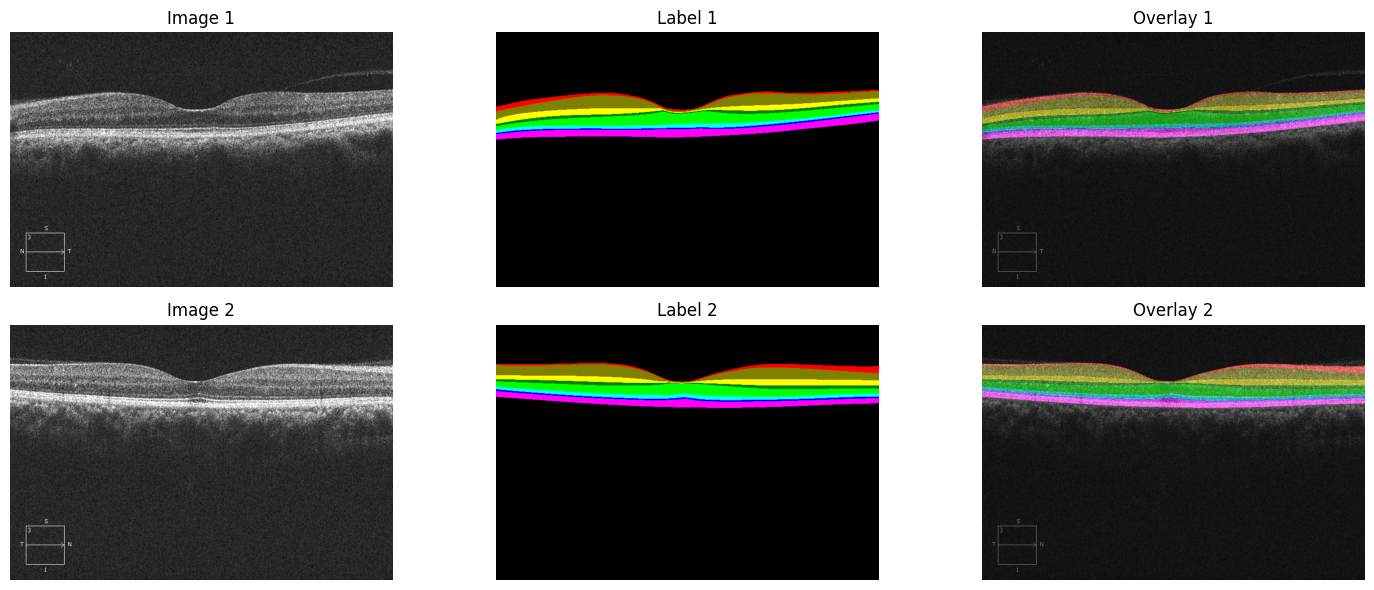

In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def load_image(image_path):
    """Load an image from a file path."""
    with Image.open(image_path) as img:
        return img.convert('RGB')  # Convert to RGB

def get_image_files(image_dir):
    """Get a list of image file paths from the directory."""
    return [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

def plot_images_with_labels(image_paths, label_paths):
    """Plot images with their corresponding labels."""
    num_images = len(image_paths)
    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 3))

    for i, (img_path, lbl_path) in enumerate(zip(image_paths, label_paths)):
        img = load_image(img_path)
        lbl = load_image(lbl_path)

        img_array = np.array(img)
        lbl_array = np.array(lbl)

        # Print image and label details
        print(f"Image Path: {img_path}")
        print(f"Image Shape: {img_array.shape}")
        print(f"Label Path: {lbl_path}")
        print(f"Label Shape: {lbl_array.shape}")

        # Plot image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Image {i+1}")
        axes[i, 0].axis('off')

        # Plot label
        axes[i, 1].imshow(lbl)
        axes[i, 1].set_title(f"Label {i+1}")
        axes[i, 1].axis('off')

        # Plot overlay
        overlay = np.where(lbl_array > 0, lbl_array, 0)  # Overlay label on image
        axes[i, 2].imshow(img)
        axes[i, 2].imshow(overlay, cmap='tab20', alpha=0.5)  # Combine with alpha blending
        axes[i, 2].set_title(f"Overlay {i+1}")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    image_directory = '/content/drive/MyDrive/Colab Notebooks/Git/Datasets/NR206_Full_Version/NR206/train'  # Replace with your image directory path
    label_directory = '/content/drive/MyDrive/Colab Notebooks/Git/Datasets/NR206_Full_Version/NR206/train_labels'

    # Load image paths and label paths
    image_files = get_image_files(image_directory)
    label_files = get_image_files(label_directory)  # Assuming labels are in the same format

    # Ensure that image and label files are correctly paired
    if len(image_files) != len(label_files):
        raise ValueError("Number of images and labels do not match.")

    # Randomly sample 10 images and corresponding labels
    sampled_indices = random.sample(range(len(image_files)), 2)  # Changed from 10 to 2 for demo
    sampled_images = [image_files[i] for i in sampled_indices]
    sampled_labels = [label_files[i] for i in sampled_indices]

    # Plot the images and their labels
    plot_images_with_labels(sampled_images, sampled_labels)


# Some thing

In [ ]:
from PIL import Image
import numpy as np

def read_image_and_get_shape(image_path):
    """Read an image from a file path, convert it to a NumPy array, and print its shape and number of channels."""
    # Open the image file
    with Image.open(image_path) as img:
        # Convert the image to a NumPy array
        img_array = np.array(img)

        # Get the shape of the array
        img_shape = img_array.shape

        # Determine the number of channels
        if len(img_shape) == 3:
            num_channels = img_shape[2]
        else:
            num_channels = 1  # Grayscale images

        # Get the dimensions
        width, height = img.size

        return img_array, img_shape, num_channels, (width, height)

# Example usage
if __name__ == "__main__":
    # Replace with your image file path
    image_path = '/content/drive/MyDrive/Colab Notebooks/Git/Datasets/NR206_Full_Version/NR206/train_labels'

    # Read image and get its shape
    img_array, img_shape, num_channels, dimensions = read_image_and_get_shape(image_path+'/NORMAL93.png')

    print(f"Image shape: {img_shape}")
    print(f"Number of channels: {num_channels}")
    print(f"Dimensions (width, height): {dimensions}")

    # Optional: If you want to see the array itself
    # print(f"Image array:\n{img_array}")


Image shape: (500, 750, 4)
Number of channels: 4
Dimensions (width, height): (750, 500)


In [ ]:
import os
train = os.listdir('/content/drive/MyDrive/Colab Notebooks/Git/Datasets/NR206_Full_Version/NR206/train')
labels=os.listdir('/content/drive/MyDrive/Colab Notebooks/Git/Datasets/NR206_Full_Version/NR206/train_labels')
for i in train:
  if(i not in labels):
    print(i + " Not found")

In [ ]:
i

'NORMAL93.png'

In [ ]:
# Define the range
start = 750
end = 1000
divisor = 32

# Find numbers divisible by 32
divisible_numbers = [num for num in range(start, end + 1) if num % divisor == 0]

# Print the results
print(f"Numbers between {start} and {end} that are divisible by {divisor}:")
print(divisible_numbers)


Numbers between 750 and 1000 that are divisible by 32:
[768, 800, 832, 864, 896, 928, 960, 992]


# Converting Data

In [ ]:
import tensorflow as tf
from pathlib import Path

def load_image(image_path, label_path, image_size=(512, 768)):
    """Load and preprocess image and label."""
    # Read image and label files
    image = tf.io.read_file(image_path)
    label = tf.io.read_file(label_path)

    # Decode image and label
    image = tf.image.decode_image(image, channels=1, expand_animations=False)  # Image is grayscale
    label = tf.image.decode_image(label, channels=4, expand_animations=False)  # Label has 4 channels

    # Ensure the image and label are correctly decoded
    image.set_shape([None, None, 1])  # Explicitly set the shape of the image
    label.set_shape([None, None, 4])  # Explicitly set the shape of the label

    # Debugging prints
    print(f"Image path: {image_path}")
    print(f"Label path: {label_path}")
    print(f"Original image shape: {image.shape}")
    print(f"Original label shape: {label.shape}")

    # Resize images and labels
    image = tf.image.resize(image, image_size)
    label = tf.image.resize(label, image_size)

    # Normalize image
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    label = tf.cast(label, tf.uint8)  # Labels are usually in [0, 255]

    return image, label

def create_tf_dataset(image_dir, label_dir, batch_size=32, image_size=(512, 768)):
    """Create a TensorFlow dataset from images and labels."""
    # Convert Path objects to strings
    image_paths = [str(path) for path in sorted(Path(image_dir).glob('*.png'))]  # Adjust file extension if needed
    label_paths = [str(path) for path in sorted(Path(label_dir).glob('*.png'))]  # Adjust file extension if needed

    # Ensure images and labels match
    assert len(image_paths) == len(label_paths), "Number of images and labels must match"

    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    # Load and preprocess data
    dataset = dataset.map(lambda img_path, lbl_path: load_image(img_path, lbl_path, image_size),
                          num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle, batch, and prefetch
    dataset = dataset.shuffle(buffer_size=100)  # Adjust buffer size as needed
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

if __name__ == "__main__":
    image_directory = '/content/drive/MyDrive/Colab Notebooks/Git/Datasets/NR206_Full_Version/NR206/train'  # Replace with your image directory path
    label_directory = '/content/drive/MyDrive/Colab Notebooks/Git/Datasets/NR206_Full_Version/NR206/train_labels'

    # Create TensorFlow dataset
    tf_dataset_train = create_tf_dataset(image_directory, label_directory)

    # Test
    image_directory = '/content/drive/MyDrive/Colab Notebooks/Git/Datasets/NR206_Full_Version/NR206/test'  # Replace with your image directory path
    label_directory = '/content/drive/MyDrive/Colab Notebooks/Git/Datasets/NR206_Full_Version/NR206/test_labels'

    # Create TensorFlow dataset
    tf_dataset_test = create_tf_dataset(image_directory, label_directory)

    # Example usage: Iterate through the dataset
    for images, labels in tf_dataset_train.take(1):  # Take one batch for example
        print(f"Images shape: {images.shape}")
        print(f"Labels shape: {labels.shape}")


Image path: Tensor("args_0:0", shape=(), dtype=string)
Label path: Tensor("args_1:0", shape=(), dtype=string)
Original image shape: (None, None, 1)
Original label shape: (None, None, 4)
Image path: Tensor("args_0:0", shape=(), dtype=string)
Label path: Tensor("args_1:0", shape=(), dtype=string)
Original image shape: (None, None, 1)
Original label shape: (None, None, 4)
Images shape: (32, 512, 768, 1)
Labels shape: (32, 512, 768, 4)


# Data Visulization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def plot_images_with_labels(dataset, num_images=2):
    """Plot images and their corresponding labels from the dataset."""
    plt.figure(figsize=(12, num_images * 4))  # Adjust size for better visibility

    for i, (images, labels) in enumerate(dataset.take(1)):  # Take one batch
        for j in range(min(num_images, images.shape[0])):
            # Convert images and labels to numpy arrays
            img_array = images[j].numpy()
            lbl_array = labels[j].numpy()

            # Plot image
            plt.subplot(num_images, 3, j * 3 + 1)
            plt.imshow(np.squeeze(img_array), cmap='gray')  # Assuming grayscale for input images
            plt.title(f"Image {j+1}")
            plt.axis('off')

            # Plot label
            plt.subplot(num_images, 3, j * 3 + 2)
            plt.imshow(lbl_array)  # No cmap needed for labels with multiple channels
            plt.title(f"Label {j+1}")
            plt.axis('off')

            # Combine images and labels for side-by-side view
            # If labels have 4 channels, we need to ensure compatibility
            #if lbl_array.shape[-1] == 4:
            #    #combined = np.concatenate((np.repeat(img_array, 4, axis=-1), lbl_array), axis=1)  # Repeat image to match the 4 channels of labels
            #else:
            #    #combined = np.concatenate((np.repeat(img_array, 4, axis=-1), np.repeat(lbl_array, 3, axis=-1)), axis=1)

            #plt.subplot(num_images, 3, j * 3 + 3)
            #plt.imshow(combined)
            #plt.title(f"Combined {j+1}")
            #plt.axis('off')


    plt.tight_layout()
    plt.show()
print("Visualizing training dataset")
plot_images_with_labels(tf_dataset_train, num_images=2)  # Plot 2 images for example
# Plot images and labels from testing dataset
print("Visualizing testing dataset")
plot_images_with_labels(tf_dataset_test, num_images=2)  # Plot 2 images for exampl


#Loss Functions

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K

# Define constants for weighting
crossentropy_weight = 1.0
dice_weight = 0.5

# Define custom weighted loss function
def combined_loss(y_true, y_pred):
    # Categorical Crossentropy Loss
    crossentropy_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

    # Dice Coefficient Loss
    dice_loss = dice_coef_loss(y_true, y_pred)

    # Combine losses with weights
    return crossentropy_weight * crossentropy_loss + dice_weight * dice_loss

# Define metrics
def dice_coef(y_true, y_pred):
    y_true = K.argmax(y_true, axis=-1)  # Convert one-hot encoded to class indices
    y_pred = K.argmax(y_pred, axis=-1)  # Convert probabilities to class indices

    dice_per_class = []
    for i in range(num_classes):
        y_true_class = K.cast(K.equal(y_true, i), dtype=tf.float32)
        y_pred_class = K.cast(K.equal(y_pred, i), dtype=tf.float32)

        intersection = K.sum(y_true_class * y_pred_class)
        union = K.sum(y_true_class) + K.sum(y_pred_class) + smooth
        dice = (2. * intersection + smooth) / union
        dice_per_class.append(dice)

    return K.mean(K.stack(dice_per_class))

def jaccard_index(y_true, y_pred):
    y_true = K.argmax(y_true, axis=-1)
    y_pred = K.argmax(y_pred, axis=-1)

    jaccard_per_class = []
    for i in range(num_classes):
        y_true_class = K.cast(K.equal(y_true, i), dtype=tf.float32)
        y_pred_class = K.cast(K.equal(y_pred, i), dtype=tf.float32)

        intersection = K.sum(y_true_class * y_pred_class)
        union = K.sum(y_true_class) + K.sum(y_pred_class) - intersection + smooth
        jaccard = intersection / union
        jaccard_per_class.append(jaccard)

    return K.mean(K.stack(jaccard_per_class))

def precision(y_true, y_pred):
    y_true = K.argmax(y_true, axis=-1)
    y_pred = K.argmax(y_pred, axis=-1)

    precision_per_class = []
    for i in range(num_classes):
        y_true_class = K.cast(K.equal(y_true, i), dtype=tf.float32)
        y_pred_class = K.cast(K.equal(y_pred, i), dtype=tf.float32)

        true_positives = K.sum(y_true_class * y_pred_class)
        predicted_positives = K.sum(y_pred_class)
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_per_class.append(precision)

    return K.mean(K.stack(precision_per_class))

def recall(y_true, y_pred):
    y_true = K.argmax(y_true, axis=-1)
    y_pred = K.argmax(y_pred, axis=-1)

    recall_per_class = []
    for i in range(num_classes):
        y_true_class = K.cast(K.equal(y_true, i), dtype=tf.float32)
        y_pred_class = K.cast(K.equal(y_pred, i), dtype=tf.float32)

        true_positives = K.sum(y_true_class * y_pred_class)
        total_positives = K.sum(y_true_class)
        recall = true_positives / (total_positives + K.epsilon())
        recall_per_class.append(recall)

    return K.mean(K.stack(recall_per_class))

def specificity(y_true, y_pred):
    y_true = K.argmax(y_true, axis=-1)
    y_pred = K.argmax(y_pred, axis=-1)

    specificity_per_class = []
    for i in range(num_classes):
        y_true_class = K.cast(K.equal(y_true, i), dtype=tf.float32)
        y_pred_class = K.cast(K.equal(y_pred, i), dtype=tf.float32)

        true_negatives = K.sum((1 - y_true_class) * (1 - y_pred_class))
        total_negatives = K.sum(1 - y_true_class)
        specificity = true_negatives / (total_negatives + K.epsilon())
        specificity_per_class.append(specificity)

    return K.mean(K.stack(specificity_per_class))



# *U net*
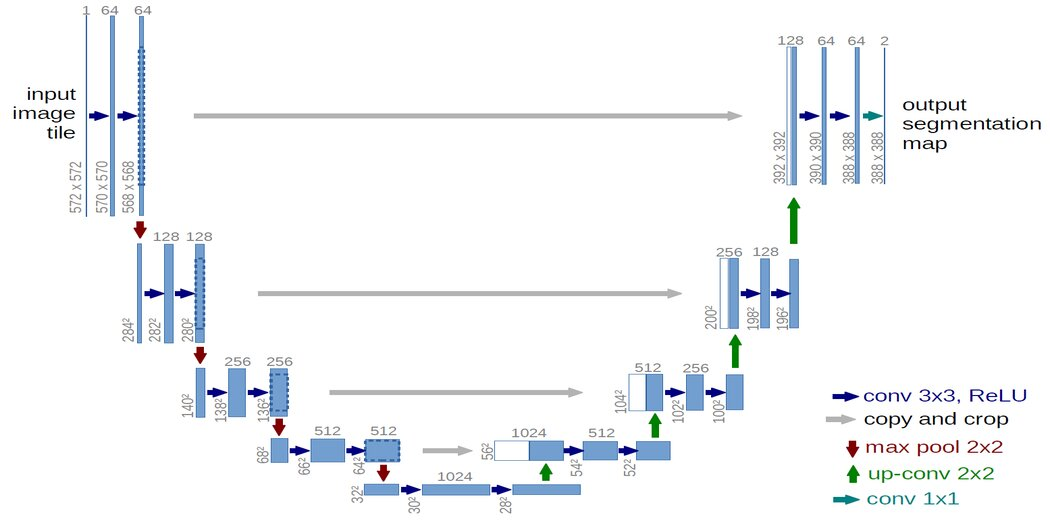

#Architecture
Deconvolution is often used in tasks like image segmentation, where the goal is to predict a mask or label for each pixel in an image. By increasing the spatial dimensions, the network can produce more precise outputs.

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Model input shape
IMG_HEIGHT = 512
IMG_WIDTH = 768
IMG_CHANNELS = 1

# Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)  # Normalize pixel values

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

# Output layer
outputs = tf.keras.layers.Conv2D(4, (1, 1), activation='softmax')(c9)  # Changed to 4 channels for segmentation

# Create the model
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])



# Model summary
model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 512, 768, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_6 (Lambda)         │ (None, 512, 768, 1)    │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_114 (Conv2D)       │ (None, 512, 768, 16)   │            160 │ lambda_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_54 (Dropout)      │ (None, 512, 768, 16)   │              0 │ conv2d_114[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_115 (Conv2D)       │ (None, 512, 768, 16)   │          2,320 │ dropout_54[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_24          │ (None, 256, 384, 16)   │              0 │ conv2d_115[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_116 (Conv2D)       │ (None, 256, 384, 32)   │          4,640 │ max_pooling2d_24[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_55 (Dropout)      │ (None, 256, 384, 32)   │              0 │ conv2d_116[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_117 (Conv2D)       │ (None, 256, 384, 32)   │          9,248 │ dropout_55[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_25          │ (None, 128, 192, 32)   │              0 │ conv2d_117[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_118 (Conv2D)       │ (None, 128, 192, 64)   │         18,496 │ max_pooling2d_25[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_56 (Dropout)      │ (None, 128, 192, 64)   │              0 │ conv2d_118[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_119 (Conv2D)       │ (None, 128, 192, 64)   │         36,928 │ dropout_56[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_26          │ (None, 64, 96, 64)     │              0 │ conv2d_119[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_120 (Conv2D)       │ (None, 64, 96, 128)    │         73,856 │ max_pooling2d_26[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_57 (Dropout)      │ (None, 64, 96, 128)    │              0 │ conv2d_120[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_121 (Conv2D)       │ (None, 64, 96, 128)    │        147,584 │ dropout_57[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_27     

 Total params: 1,940,868 (7.40 MB)

 Trainable params: 1,940,868 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True)

# Compile

In [ ]:
# Compile the model with the combined loss and metrics
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=combined_loss,
              metrics=['accuracy', dice_coef, jaccard_index, precision, recall, specificity])

In [ ]:
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

# Define your callbacks
filepath = 'saved_models/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
log_csv = CSVLogger('training_logs.csv', separator=',', append=False)
#early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Model Fit

In [ ]:
# Train the model with the defined callbacks
history = model.fit(tf_dataset_train,
                    validation_data=tf_dataset_test,
                    epochs=40,
                    callbacks=[checkpoint, log_csv]) #early_stop


Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5252 - dice_coef: 0.2038 - jaccard_index: 0.1485 - loss: 23978.7422 - precision: 0.2493 - recall: 0.2497 - specificity: 0.7498
Epoch 1: val_accuracy improved from -inf to 0.55739, saving model to saved_models/weights-improvement-01-0.56.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5262 - dice_coef: 0.2040 - jaccard_index: 0.1487 - loss: 25564.1582 - precision: 0.2493 - recall: 0.2497 - specificity: 0.7498 - val_accuracy: 0.5574 - val_dice_coef: 0.2045 - val_jaccard_index: 0.1537 - val_loss: 36344.1836 - val_precision: 0.2391 - val_recall: 0.2491 - val_specificity: 0.7492
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5510 - dice_coef: 0.2083 - jaccard_index: 0.1546 - loss: 101513.9609 - precision: 0.2493 - recall: 0.2496 - specificity: 0.7498
Epoch 2: val_accuracy improved from 0.55739 to 0.58753, saving model to saved_models/weights-improvement-02-0.59.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - ac

# Visualizer

In [ ]:
pip install visualkeras


In [ ]:
import visualkeras
from PIL import Image

# Visualize the model
visualkeras.layered_view(model, legend=True,to_file = 'model.png').show()

# Alternatively, if you want to display it in a Jupyter Notebook or similar environment:
from IPython.display import Image
Image('model.png')

In [ ]:
print(type(tf_dataset_train))
print(type(tf_dataset_test))

# Optional: check the first few elements to ensure they are correctly formatted
for image, label in tf_dataset_train.take(1):
    print(image.shape, label.shape)


<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
(32, 512, 768, 1) (32, 512, 768, 4)


In [ ]:
print(type(tf_dataset_train))
print(type(tf_dataset_test))


<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


#Ploting Loss Vs Epochs

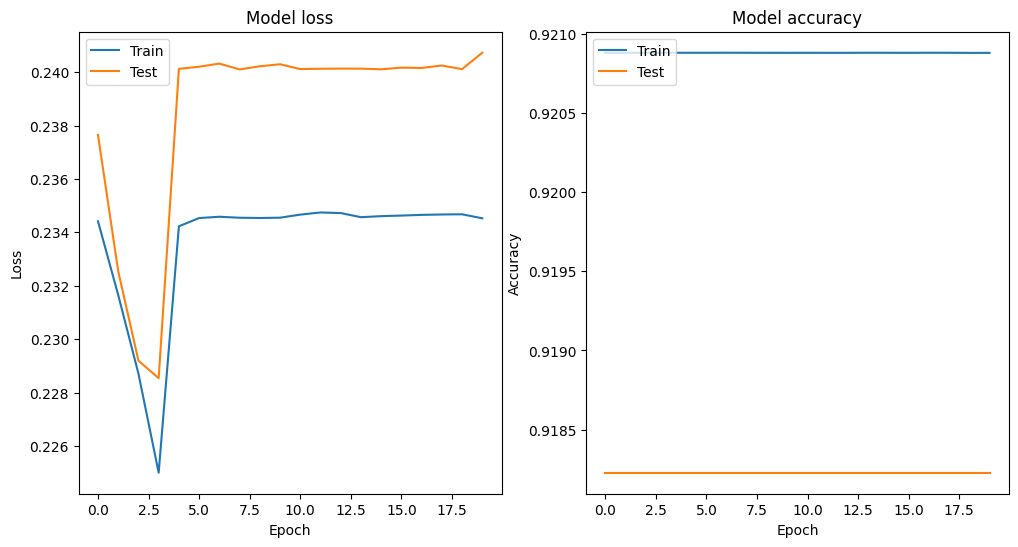

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


# Testing Some samples

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


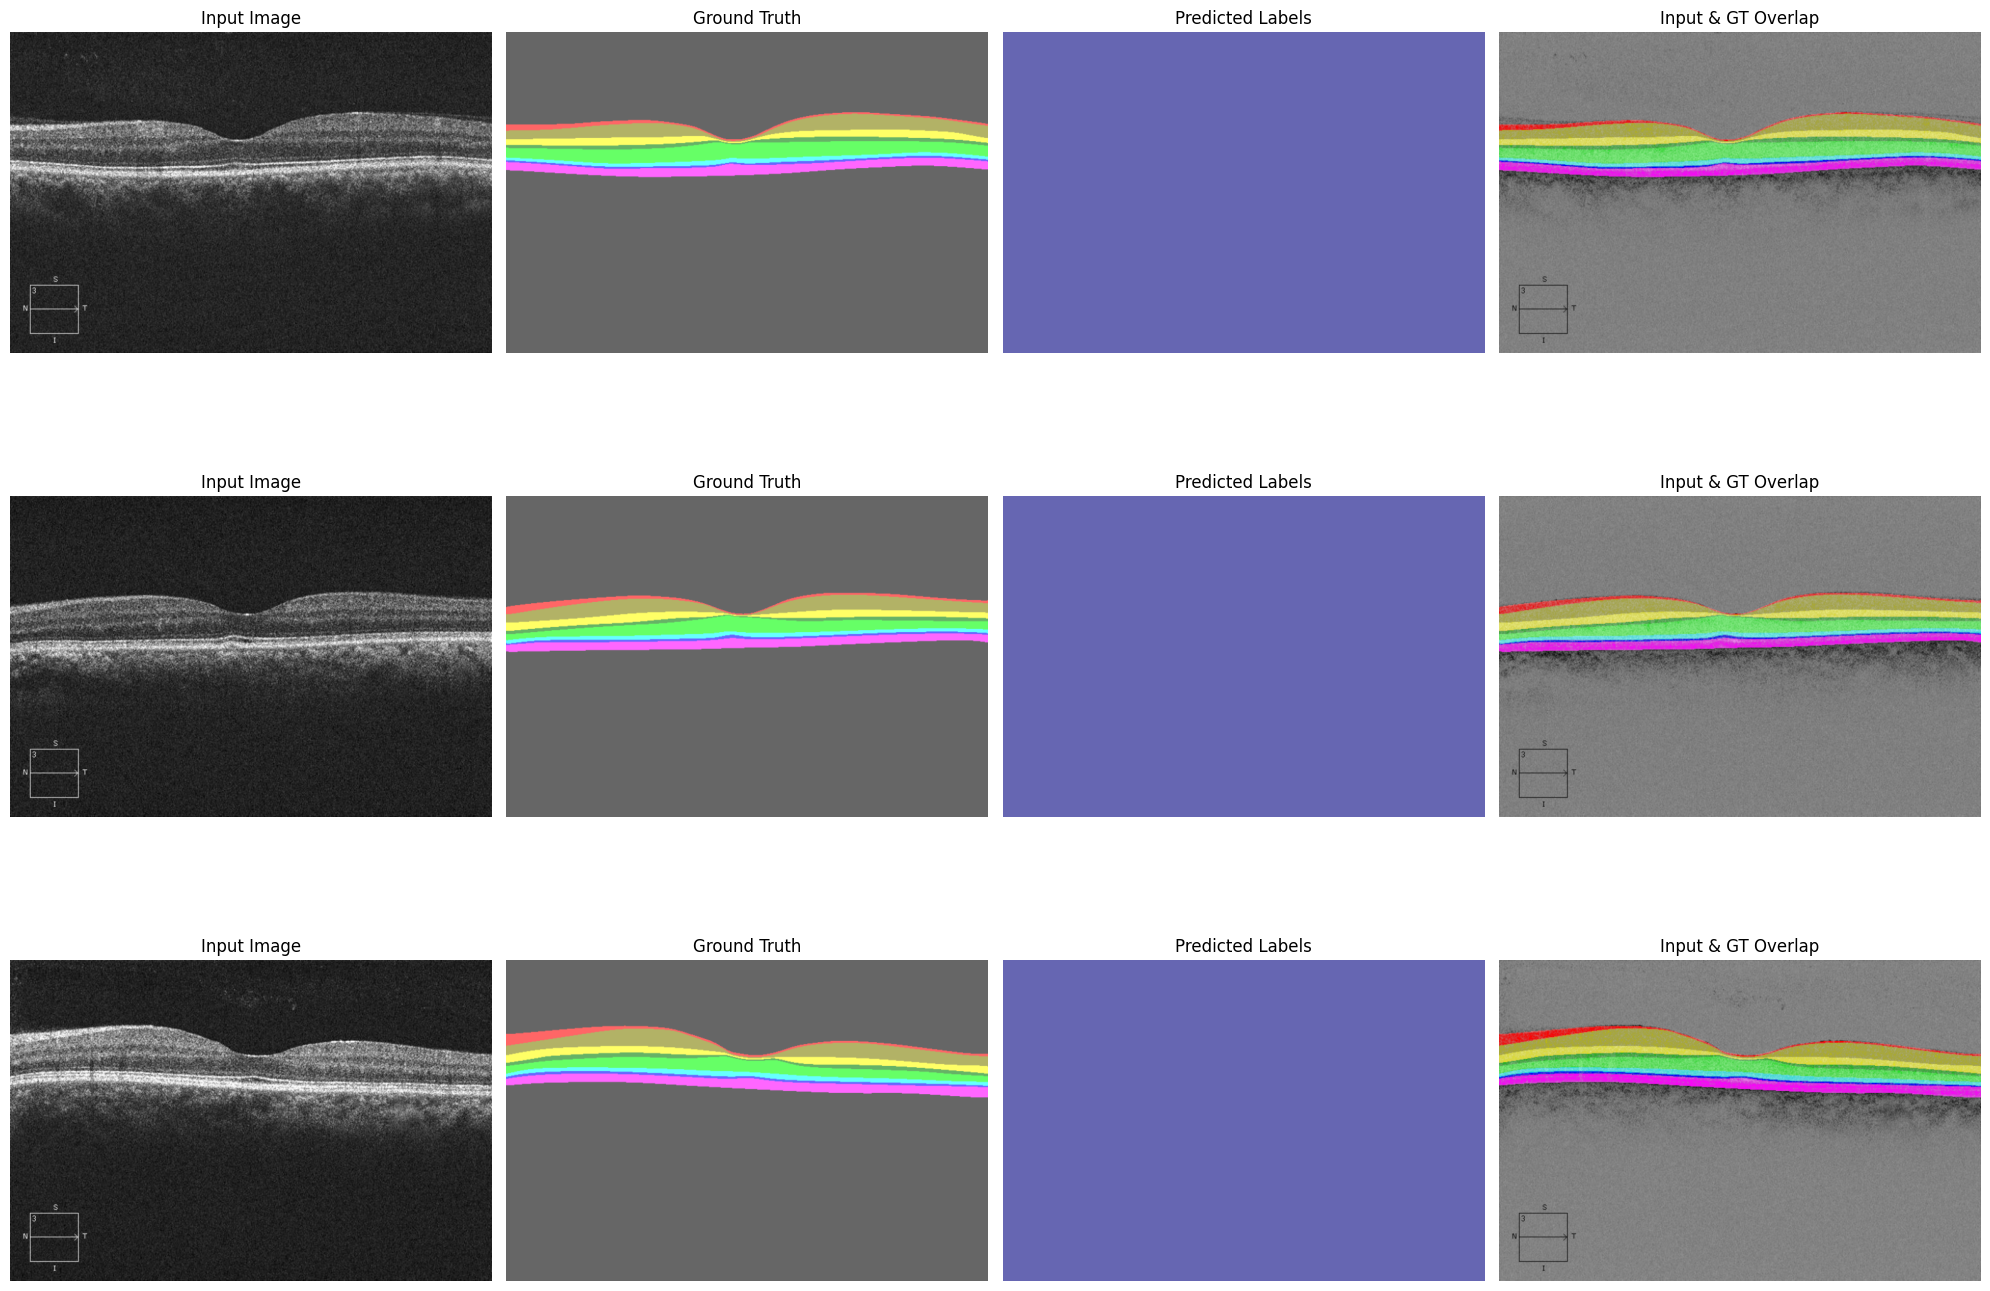

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to plot the images
def plot_images(input_images, ground_truth, predictions):
    num_images = len(input_images)
    fig, axes = plt.subplots(num_images, 4, figsize=(20, num_images * 5))

    for i in range(num_images):
        # Plot Input Image
        axes[i, 0].imshow(input_images[i], cmap='gray')
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')

        # Plot Ground Truth
        axes[i, 1].imshow(ground_truth[i], cmap='jet', alpha=0.6)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        # Plot Predicted Labels
        axes[i, 2].imshow(predictions[i], cmap='jet', alpha=0.6)
        axes[i, 2].set_title('Predicted Labels')
        axes[i, 2].axis('off')

        # Plot Overlap between Input Image and Ground Truth
        overlap_gt = np.copy(input_images[i])
        overlap_gt = np.where(ground_truth[i] > 0, overlap_gt, 0)
        axes[i, 3].imshow(overlap_gt, cmap='gray')
        axes[i, 3].imshow(ground_truth[i], cmap='jet', alpha=0.4)
        axes[i, 3].set_title('Input & GT Overlap')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

# Function to get a batch of validation images
def get_validation_batch(dataset, batch_size=3):
    images, labels = [], []
    for img_batch, lbl_batch in dataset:
        images.extend(img_batch.numpy())
        labels.extend(lbl_batch.numpy())
        if len(images) >= batch_size:
            break
    return np.array(images[:batch_size]), np.array(labels[:batch_size])

# Assuming `val_dataset` is your validation dataset and `model` is your trained model
# Get a batch of validation images
input_images, ground_truth = get_validation_batch(tf_dataset_test)

# Predict labels for the batch
predictions = model.predict(input_images)

# Convert predictions to the same shape as ground truth (e.g., using argmax for categorical predictions)
predictions = np.argmax(predictions, axis=-1)

# Plot the results
plot_images(input_images, ground_truth, predictions)
